# 2_Exploratory Data Analysis

In [577]:
import numpy as np
from matplotlib.dates import DayLocator, MonthLocator, DateFormatter
from matplotlib.ticker import AutoLocator
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import statsmodels.api as sm

#Import Plots
#from src.plotting import plot_config
#from src.plotting import plot_variable_with_maneuvers

In [403]:
orbital_file = r"C:\Users\Suare\satellite_anomaly_project\data\cleaned\all_satellite_orbitals.csv"
maneuver_file = r"C:\Users\Suare\satellite_anomaly_project\data\cleaned\cleaned_maneuvers.csv"

In [405]:
df_orbital = pd.read_csv(orbital_file)
df_maneuver = pd.read_csv(maneuver_file)

# Plots

In [613]:
def plot_acf_pacf(df_orbital, satellite_name, variable, lags=30, figsize=(16, 4), 
                  save_path=None, adjust_y_axis=True, dpi=300):
    """
    Plot ACF and PACF for a selected satellite and variable.
    
    Parameters:
    -----------
    df_orbital : pandas DataFrame
        The dataframe containing orbital data for multiple satellites
    satellite_name : str
        The name of the satellite to filter for
    variable : str
        The variable/column name to analyze
    lags : int, default=30
        Number of lags to include in the plots
    figsize : tuple, default=(16, 4)
        Size of the figure (width, height)
    save_path : str or None, default=None
        Path to save the figure. If None, the figure is not saved
    adjust_y_axis : bool, default=True
        Whether to adjust the y-axis limits based on the data
    dpi : int, default=300
        Resolution for the saved figure
        
    Returns:
    --------
    fig : matplotlib Figure
        The figure object containing the plots
    """
    # Filter the dataframe for the specified satellite
    df_filtered =df_orbital[df_orbital['satellite_name'] == satellite_name].copy()
    
    # Check if the filtered dataframe is empty
    if df_filtered.empty:
        raise ValueError(f"No data found for satellite '{satellite_name}'")
    
    # Check if the variable exists in the dataframe
    if variable not in df_filtered.columns:
        raise ValueError(f"Variable '{variable}' not found in the dataframe")
    
    # Get the data series for the specified variable
    data_series = df_filtered[variable]
    
    # Create the figure and subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
    
    # Calculate ACF and PACF values
    acf_values = sm.tsa.acf(data_series, nlags=lags)
    pacf_values = sm.tsa.pacf(data_series, nlags=lags)
    
    # Plot ACF - use the statsmodels plot_acf function with the specified axis
    sm.graphics.tsa.plot_acf(data_series, lags=lags, ax=axes[0], alpha=0.05)
    axes[0].set_title(f"Autocorrelation Function (ACF)")
    axes[0].set_xlabel(f"Lag (days)")
    axes[0].set_ylabel("Correlation coefficient")
    
    # Plot PACF - use the statsmodels plot_pacf function with the specified axis
    sm.graphics.tsa.plot_pacf(data_series, lags=lags, ax=axes[1], alpha=0.05)
    axes[1].set_title(f"Partial Autocorrelation Function (PACF)")
    axes[1].set_xlabel(f"Lag (days)")
    axes[1].set_ylabel("Correlation coefficient")
    
    # Adjust y-axis limits if requested
    if adjust_y_axis:
        # Find min and max values, adding a small buffer
        min_val = min(min(acf_values), min(pacf_values)) - 0.05
        max_val = max(max(acf_values), max(pacf_values)) + 0.05
        
        # Ensure the range is at least 0.2 to avoid too narrow plots
        if max_val - min_val < 0.2:
            mean = (max_val + min_val) / 2
            min_val = mean - 0.1
            max_val = mean + 0.1
        
        # Set the limits but don't exceed the standard -1 to 1 range
        y_min = max(-1, min_val)
        y_max = min(1, max_val)
        
        axes[0].set_ylim(y_min, y_max)
        axes[1].set_ylim(y_min, y_max)
    
    plt.tight_layout()
    
    # Save the figure if a path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"Figure saved to {save_path}")

In [474]:
def plot_variable_with_maneuvers(df_orbital, df_maneuver, satellite_name, variable,
                              start_epoch=None, end_epoch=None, units=None,
                              config=None, save_path=None, show_markers=False):
    
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import pandas as pd
    from matplotlib import rcParams
    
    # Better font configuration for saved figures
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
    
    # Figure size and DPI settings that work well for both display and saving
    if save_path is None:
        fig_size = (10, 5)
        font_size = 11
        dpi = 100
    else:
        fig_size = (8, 4)  # Better size ratio for Word documents
        font_size = 12     # Slightly larger for readability in documents
        dpi = 300
    
    # Set font sizes
    rcParams.update({
        'font.size': font_size,
        'axes.titlesize': font_size + 1,
        'axes.labelsize': font_size,
        'xtick.labelsize': font_size - 1,
        'ytick.labelsize': font_size - 1,
        'legend.fontsize': font_size - 1,
    })
    
    default_units = {
        'Brouwer mean motion': 'rad/s',
        'eccentricity': '',
        'argument of perigee': 'rad',
        'inclination': 'rad',
        'mean anomaly': 'rad',
        'right ascension': 'rad'
    }
    
    default_config = {
        "line_color_orbital": "deepskyblue",
        "line_color_residuals": "orange",
        "line_color_maneuvers": "navy",
        "tick_color": "black",
        "frame_color": "#cccccc",
        "marker": "o" if show_markers else None,
        "marker_size": 4,
        "marker_freq": 20  # Show marker every N points
    }
    
    if config is None:
        config = default_config
    else:
        # Merge user config with defaults
        for key, value in default_config.items():
            if key not in config:
                config[key] = value
    
    # Handle marker settings
    if show_markers and "marker" not in config:
        config["marker"] = "o"
        config["marker_size"] = 4
    
    df_sat_orbital = df_orbital[df_orbital['satellite_name'] == satellite_name].copy()
    df_sat_maneuver = df_maneuver[df_maneuver['OrbitalKeyName'] == satellite_name].copy()
    
    if df_sat_orbital.empty:
        print(f"No orbital data found for {satellite_name}")
        return
    
    if df_sat_maneuver.empty:
        print(f"No maneuver data found for {satellite_name}")
    
    # Ensure datetime type
    df_sat_orbital['epoch_date'] = pd.to_datetime(df_sat_orbital['epoch_date'])
    if not df_sat_maneuver.empty:
        df_sat_maneuver['start_date'] = pd.to_datetime(df_sat_maneuver['start_date'])
    
    # Apply zoom filters
    if start_epoch:
        start_epoch = pd.to_datetime(start_epoch)
        df_sat_orbital = df_sat_orbital[df_sat_orbital['epoch_date'] >= start_epoch]
        if not df_sat_maneuver.empty:
            df_sat_maneuver = df_sat_maneuver[df_sat_maneuver['start_date'] >= start_epoch]
    
    if end_epoch:
        end_epoch = pd.to_datetime(end_epoch)
        df_sat_orbital = df_sat_orbital[df_sat_orbital['epoch_date'] <= end_epoch]
        if not df_sat_maneuver.empty:
            df_sat_maneuver = df_sat_maneuver[df_sat_maneuver['start_date'] <= end_epoch]
    
    # Create the figure with appropriate size
    fig, ax = plt.subplots(figsize=fig_size, dpi=dpi)
    
    # If showing markers but we have many data points, show them less frequently
    if show_markers and len(df_sat_orbital) > config["marker_freq"]:
        # Plot line without markers
        plt.plot(df_sat_orbital['epoch_date'], df_sat_orbital[variable],
                 color=config["line_color_orbital"],
                 linewidth=0.9)
        
        # Add markers at reduced frequency
        marker_data = df_sat_orbital.iloc[::config["marker_freq"]]
        plt.plot(marker_data['epoch_date'], marker_data[variable],
                 label=variable,
                 color=config["line_color_orbital"],
                 marker=config["marker"],
                 markersize=config["marker_size"],
                 linestyle='none')
    else:
        # Plot time series with or without markers
        plt.plot(df_sat_orbital['epoch_date'], df_sat_orbital[variable],
                 label=variable,
                 color=config["line_color_orbital"],
                 linewidth=0.9,
                 marker=config["marker"],
                 markersize=config.get("marker_size", 4) if show_markers else None,
                 markevery=config.get("marker_freq", 20) if show_markers else None)
    
    # Vertical lines for maneuvers
    maneuver_plotted = False
    if not df_sat_maneuver.empty:
        for i, row in df_sat_maneuver.iterrows():
            plt.axvline(
                x=row['start_date'],
                color=config["line_color_maneuvers"],
                alpha=0.8,
                linestyle="--",
                linewidth=1,
                label="Manoeuvre Timestamp" if not maneuver_plotted else ""
            )
            maneuver_plotted = True
    
    # Axis formatting
    unit = units if units else default_units.get(variable, "")
    plt.ylabel(unit, color=config["tick_color"])
    plt.xticks(color=config["tick_color"])
    plt.yticks(color=config["tick_color"])
    
    
    # Legend positioning - always at top left
    #plt.legend(loc="upper left", frameon=False)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False)
    
    # Smart date formatting
    if len(df_sat_orbital) >= 2:
        t_start = df_sat_orbital['epoch_date'].min()
        t_end = df_sat_orbital['epoch_date'].max()
        duration = (t_end - t_start).days
        
        if duration > 365*2:
            date_fmt = '%Y'
        elif duration > 180:
            date_fmt = '%Y-%m'
        elif duration > 30:
            date_fmt = '%Y-%m-%d'
        else:
            date_fmt = '%m-%d %H:%M'
        
        # Force specific date format for your case
        if duration > 180 and duration < 500:  # ~1-1.5 years
            date_fmt = '%Y-%m'
            
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter(date_fmt))
    
    # Frame color
    for spine in ax.spines.values():
        spine.set_color(config["frame_color"])
    
    # Set x-limits explicitly if provided
    if start_epoch is not None and end_epoch is not None:
        plt.xlim(start_epoch, end_epoch)
    
    # Set y-limits with a small margin
    y_min = df_sat_orbital[variable].min()
    y_max = df_sat_orbital[variable].max()
    y_range = y_max - y_min
    margin = max(y_range * 0.05, 0.000001)  # At least 0.000001 or 5% of range
    plt.ylim(y_min - margin, y_max + margin)
    
    # Tight layout for better use of space
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    
    plt.show()
    plt.close()

In [476]:
#Plot several variables at the same time
def plot_multiple_satellite_variables(df_orbital, df_maneuver, satellite_name, variables, start_epoch=None, end_epoch=None):
    """
    Calls `plot_satellite_variable_with_maneuvers` for each variable in the list.
    This generates one plot per variable.

    Args:
        df_orbital (pd.DataFrame): The orbital dataset.
        df_maneuver (pd.DataFrame): The maneuver dataset.
        satellite_name (str): The name of the satellite to filter.
        variables (list or set of str): A list or set of orbital parameters to plot.
        start_epoch (str or None): Start date-time for zooming in (format: 'YYYY-MM-DD HH:MM:SS'). If None, full range is used.
        end_epoch (str or None): End date-time for zooming in (format: 'YYYY-MM-DD HH:MM:SS'). If None, full range is used.
    """
    for variable in variables:
        print(f"\nPlotting {variable} for {satellite_name}...\n")
        plot_variable_with_maneuvers(df_orbital, df_maneuver, satellite_name, variable, start_epoch, end_epoch)

In [478]:
def plot_multivariable_with_maneuvers(df_orbital, df_maneuver, satellite_name, variables,
                                      start_epoch, end_epoch, save_path=None):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import pandas as pd
    
    # Font and layout settings
    plt.rcParams.update({
        'font.size': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'DejaVu Sans']
    })

    df = df_orbital[df_orbital['satellite_name'] == satellite_name].copy()
    df['epoch_date'] = pd.to_datetime(df['epoch_date'])
    df = df[(df['epoch_date'] >= pd.to_datetime(start_epoch)) & (df['epoch_date'] <= pd.to_datetime(end_epoch))]

    maneuvers = df_maneuver[df_maneuver['OrbitalKeyName'] == satellite_name].copy()
    maneuvers['start_date'] = pd.to_datetime(maneuvers['start_date'])
    maneuvers = maneuvers[(maneuvers['start_date'] >= pd.to_datetime(start_epoch)) & 
                          (maneuvers['start_date'] <= pd.to_datetime(end_epoch))]

    # Setup figure and axes
    fig, axes = plt.subplots(len(variables), 1, figsize=(8, 10), sharex=True, dpi=300)

    for i, var in enumerate(variables):
        ax = axes[i]
        ax.plot(df['epoch_date'], df[var], color='deepskyblue', linewidth=0.9)

        for _, row in maneuvers.iterrows():
            ax.axvline(row['start_date'], color='navy', linestyle='--', linewidth=1, alpha=0.8)

        #ax.set_ylabel(var, rotation=90, ha='right', va='center', labelpad=20)

        # Style
        ax.grid(False, axis='y', linestyle='--', alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Format the x-axis only at the bottom
    axes[-1].xaxis.set_major_locator(mdates.AutoDateLocator())
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    fig.tight_layout(h_pad=1.0)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight')
        print(f"Saved figure to {save_path}")

    plt.show()
    plt.close()

In [480]:
def plot_multiple_variables_with_maneuvers(df_orbital, df_maneuver, satellite_name, variables_list,
                                           start_epoch=None, end_epoch=None, config=None,
                                           save_path=None, show_markers=False):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import pandas as pd
    from matplotlib import rcParams

    # Better font configuration
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']

    if save_path is None:
        fig_size = (10, 2.5 * len(variables_list))
        font_size = 11
        dpi = 100
    else:
        fig_size = (8, 2 * len(variables_list))
        font_size = 12
        dpi = 300

    rcParams.update({
        'font.size': font_size,
        'axes.titlesize': font_size + 1,
        'axes.labelsize': font_size,
        'xtick.labelsize': font_size - 1,
        'ytick.labelsize': font_size - 1,
        'legend.fontsize': font_size - 1,
    })

    # Scaled eccentricity for better axis alignment
    df_orbital = df_orbital.copy()
    df_orbital['eccentricity_scaled'] = df_orbital['eccentricity'] * 1e4

    default_units = {
        'Brouwer mean motion': 'Mean motion (rad/s)',
        'eccentricity_scaled': 'Eccentricity (×10^-4)',
        'argument of perigee': 'Arg. of perigee (rad)',
        'inclination': 'Inclination (rad)',
        'mean anomaly': 'Mean anomaly (rad)',
        'right ascension': 'Right ascension (rad)'
    }

    default_config = {
        "line_color_orbital": "deepskyblue",
        "line_color_maneuvers": "navy",
        "tick_color": "grey",
        "frame_color": "grey"
    }

    config = config or default_config

    df_sat_orbital = df_orbital[df_orbital['satellite_name'] == satellite_name].copy()
    df_sat_maneuver = df_maneuver[df_maneuver['OrbitalKeyName'] == satellite_name].copy()

    df_sat_orbital['epoch_date'] = pd.to_datetime(df_sat_orbital['epoch_date'])
    if not df_sat_maneuver.empty:
        df_sat_maneuver['start_date'] = pd.to_datetime(df_sat_maneuver['start_date'])

    # Apply date filters
    if start_epoch:
        start_epoch = pd.to_datetime(start_epoch)
        df_sat_orbital = df_sat_orbital[df_sat_orbital['epoch_date'] >= start_epoch]
        df_sat_maneuver = df_sat_maneuver[df_sat_maneuver['start_date'] >= start_epoch]
    if end_epoch:
        end_epoch = pd.to_datetime(end_epoch)
        df_sat_orbital = df_sat_orbital[df_sat_orbital['epoch_date'] <= end_epoch]
        df_sat_maneuver = df_sat_maneuver[df_sat_maneuver['start_date'] <= end_epoch]

    # Date format logic
    if len(df_sat_orbital) >= 2:
        duration = (df_sat_orbital['epoch_date'].max() - df_sat_orbital['epoch_date'].min()).days
        if duration > 365 * 2:
            date_fmt = '%Y'
        elif duration > 180:
            date_fmt = '%Y-%m'
        elif duration > 30:
            date_fmt = '%Y-%m-%d'
        else:
            date_fmt = '%m-%d %H:%M'
        if 180 < duration < 500:
            date_fmt = '%Y-%m'
    else:
        date_fmt = '%Y-%m'

    fig, axes = plt.subplots(len(variables_list), 1, figsize=fig_size,
                             sharex=True, gridspec_kw={'hspace': 0})

    plt.subplots_adjust(left=0.2, right=0.98, top=0.94, bottom=0.08, hspace=0.2)

    legend_elements = {}

    for i, variable in enumerate(variables_list):
        ax = axes[i]

        y_data = df_sat_orbital[variable]
        line, = ax.plot(df_sat_orbital['epoch_date'], y_data,
                        color=config["line_color_orbital"],
                        linewidth=1.0)

        label = default_units.get(variable, "")
        ax.set_ylabel(label)

        if not df_sat_maneuver.empty:
            for _, row in df_sat_maneuver.iterrows():
                maneuver_line = ax.axvline(x=row['start_date'],
                                           color=config["line_color_maneuvers"],
                                           linestyle="--",
                                           linewidth=1,
                                           alpha=0.8)
                if "Manoeuvre Timestamp" not in legend_elements:
                    legend_elements["Manoeuvre Timestamp"] = maneuver_line
                    legend_elements["Orbital Elements"] = line

        ax.tick_params(axis='y', colors=config["tick_color"])
        ax.grid(False)  
        for spine in ax.spines.values():
            spine.set_color(config["frame_color"])
        ax.yaxis.set_major_locator(plt.MaxNLocator(4))

        if i == len(variables_list) - 1:
            ax.tick_params(axis='x', colors=config["tick_color"])
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter(date_fmt))
        else:
            ax.tick_params(axis='x', labelbottom=False)

    fig.legend(
        handles=list(legend_elements.values()),
        labels=list(legend_elements.keys()),
        loc="upper center",
        bbox_to_anchor=(0.5, 0.985),
        ncol=len(legend_elements),
        frameon=False
    )

    if start_epoch and end_epoch:
        axes[0].set_xlim(start_epoch, end_epoch)

    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"Figure saved to {save_path}")

    plt.show()
    plt.close()

# Exploration Plots

In [482]:
variables_to_plot1 =  ["Brouwer mean motion", "eccentricity", "argument of perigee","right ascension", "inclination", "mean anomaly"]

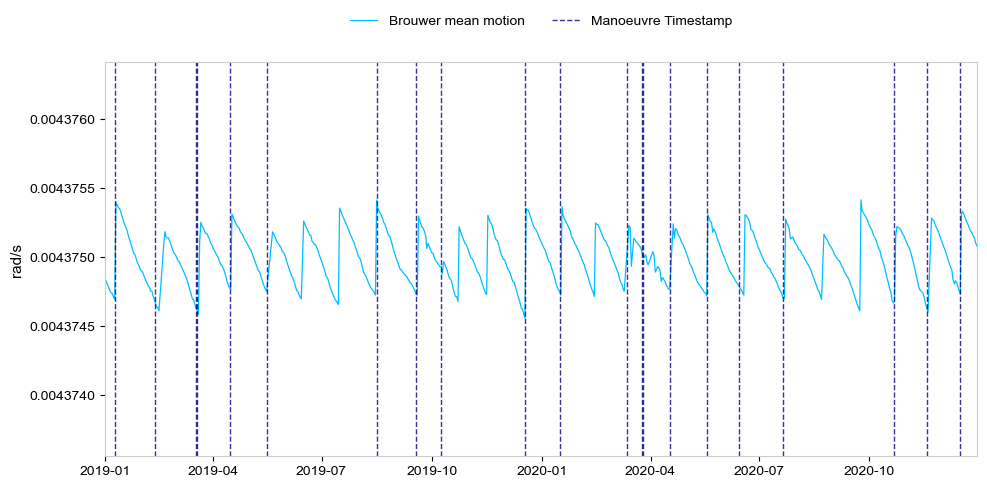

In [484]:
plot_variable_with_maneuvers(df_orbital, df_maneuver, "Fengyun_4A", "Brouwer mean motion", 
                             "2019-01-01","2020-12-30", save_path=None)


Plotting Brouwer mean motion for Fengyun_4A...



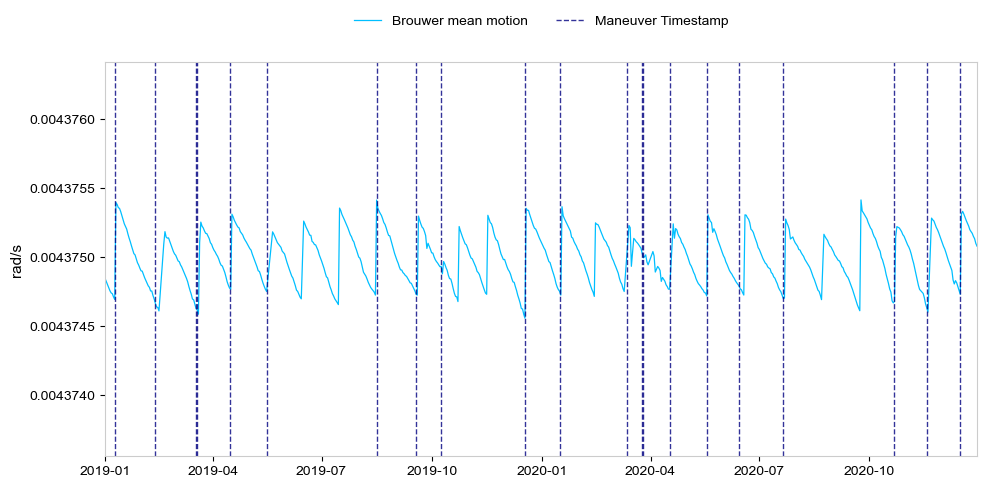


Plotting eccentricity for Fengyun_4A...



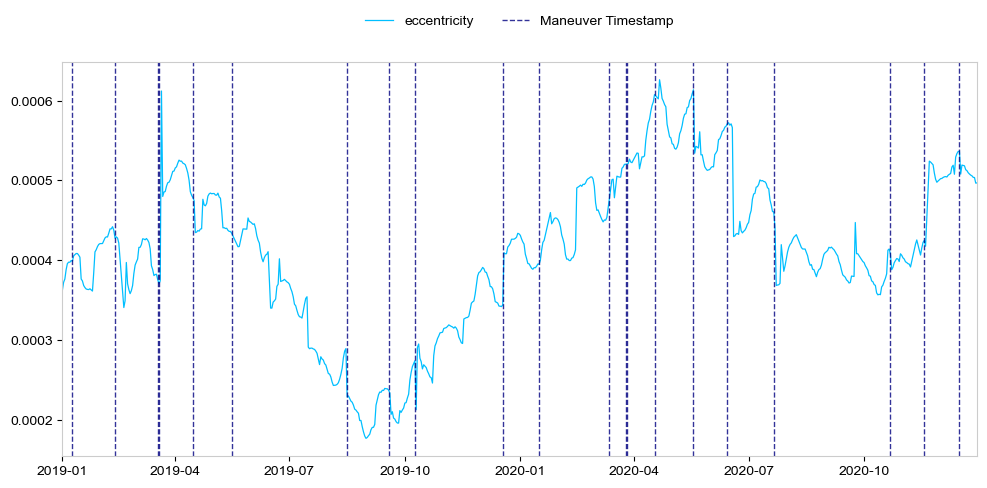


Plotting argument of perigee for Fengyun_4A...



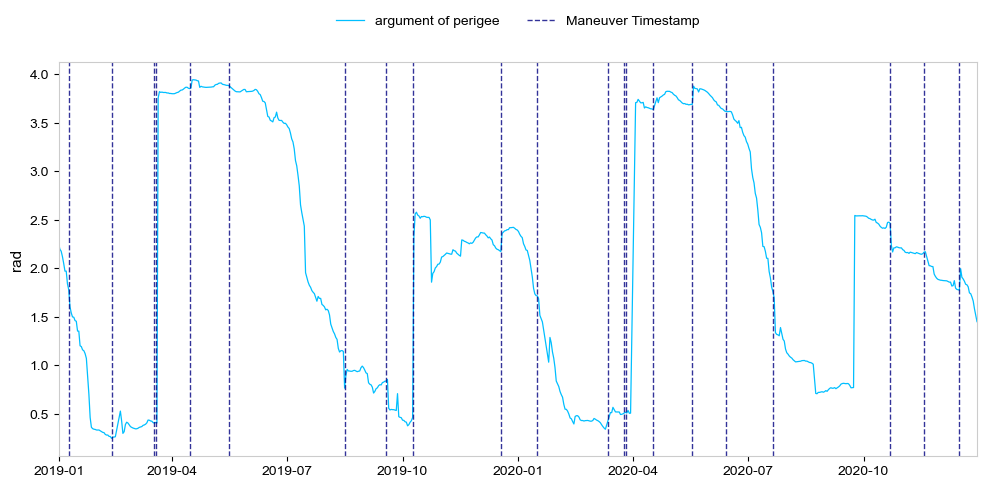


Plotting right ascension for Fengyun_4A...



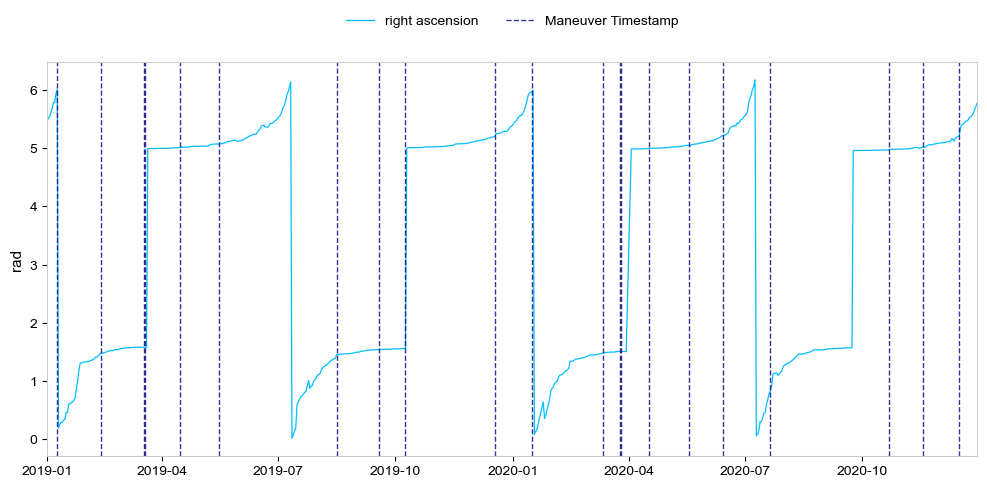


Plotting inclination for Fengyun_4A...



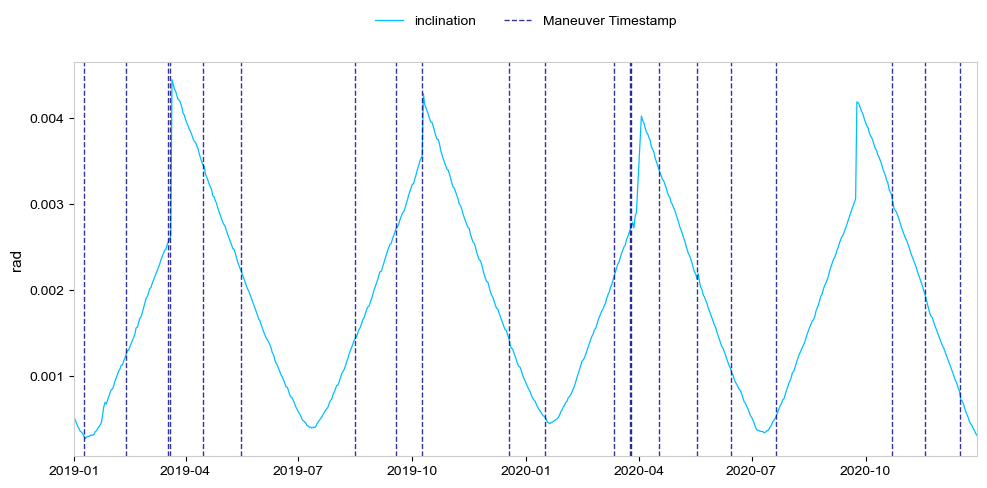


Plotting mean anomaly for Fengyun_4A...



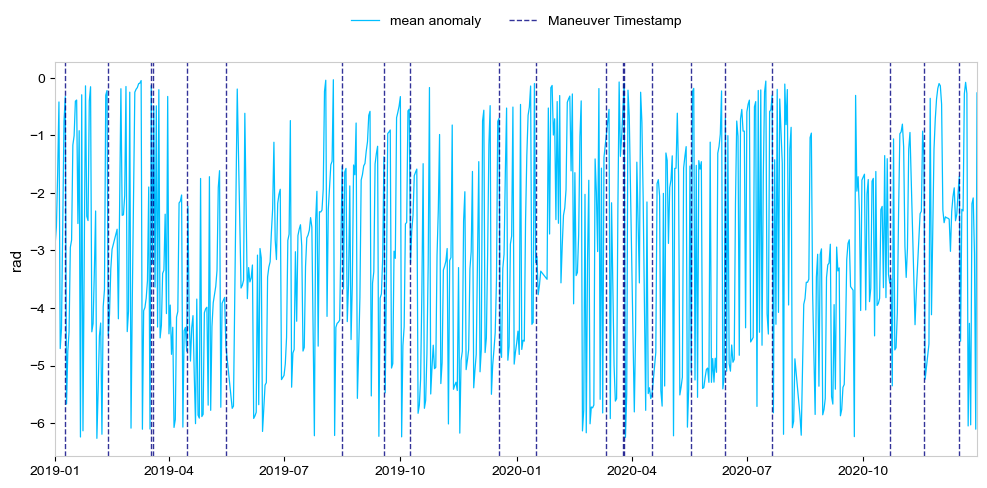

In [472]:
plot_multiple_satellite_variables(df_orbital, df_maneuver, "Fengyun_4A", variables_to_plot1,"2019-01-01","2020-12-30")

# Summary Table

In [413]:
# Function to create the summary table
def create_satellite_summary_table(df_orbital, df_maneuver, satellites):
    """
    Creates a summary table with the specified metrics for each satellite.
    
    Parameters:
    - df_orbital: DataFrame containing orbital elements data
    - df_maneuver: DataFrame containing maneuver data
    - satellites: List of satellite names to include in the table
    
    Returns:
    - DataFrame with satellites as columns and metrics as rows
    """
    # Initialize dictionary to store results
    summary_data = {}
    
    # Ensure datetime columns are in datetime format
    df_orbital['epoch_date'] = pd.to_datetime(df_orbital['epoch_date'])
    df_maneuver['start_datetime'] = pd.to_datetime(df_maneuver['start_datetime'])
    df_maneuver['end_datetime'] = pd.to_datetime(df_maneuver['end_datetime'])
    df_maneuver['start_date'] = pd.to_datetime(df_maneuver['start_date'])

    # Get min and max dates from the orbital dataset
    start_range = df_orbital['epoch_date'].min()
    end_range = df_orbital['epoch_date'].max()
    # Filter maneuver rows where the maneuver period overlaps the orbital data range
    df_maneuver = df_maneuver[(df_maneuver['end_datetime'] >= start_range) & (df_maneuver['start_datetime'] <= end_range)]
    
    # These dictionaries should be provided by you - these are just placeholders
    # Variables with potential signals for maneuvers (will be sourced manually)
    maneuver_signal_vars = {
        "Fengyun_2E": ["Brouwer mean motion", "eccentricity", "inclination"],
        "Fengyun_2F": ["Brouwer mean motion", "eccentricity", "argument of perigee", "right ascension"],
        "Fengyun_4A": ["mean anomaly", "inclination", "right ascension"],
        "Jason_3": ["Brouwer mean motion", "argument of perigee"],
        "Sentinel_3A": ["eccentricity", "inclination", "right ascension"]
    }
    
    # Define whether satellites have extreme values (will be sourced manually)
    extreme_values_dict = {
        "Fengyun_2E": "Yes",
        "Fengyun_2F": "Yes",
        "Fengyun_4A": "No",
        "Jason_3": "Yes",
        "Sentinel_3A": "No"
    }
    
    # Missing maneuvers due to quality (will be sourced manually)
    missing_maneuvers_quality = {
        "Fengyun_2E": 3,
        "Fengyun_2F": 2,
        "Fengyun_4A": 5,
        "Jason_3": 1,
        "Sentinel_3A": 4
    }
    
    # Define metrics to calculate
    metrics = [
        "Time Period", 
        "Number of Records",
        "Missing Timestamps",
        "Number of Maneuvers",
        "Missing Maneuvers (Quality)",
        "Maneuvers Per Year",
        "Median Days Between Maneuvers",
        "Maneuvers Within 6 Days",
        "Max Duration of Maneuvers (hours)",
        "Extreme Values",
        "Variables with Maneuver Signals",
        "Maneuvers on Missing Timestamps (%)",
        "Same Day Maneuvers",         
        "Duplicate Maneuvers"
    ]
    
    # Calculate metrics for each satellite
    for sat in satellites:
        # Filter data for this satellite
        sat_orbital = df_orbital[df_orbital['satellite_name'] == sat]
        sat_maneuver = df_maneuver[df_maneuver['OrbitalKeyName'] == sat]
        
        # Skip if no data for this satellite
        if len(sat_orbital) == 0:
            print(f"No orbital data found for {sat}")
            continue
        
        # Initialize results for this satellite
        summary_data[sat] = {}
        
        # 1. Time Period
        if not sat_orbital.empty:
            min_date = sat_orbital['epoch_date'].min().strftime('%Y-%m-%d')
            max_date = sat_orbital['epoch_date'].max().strftime('%Y-%m-%d')
            summary_data[sat]["Time Period"] = f"{min_date} to {max_date}"
        else:
            summary_data[sat]["Time Period"] = "No data"
        
        # 2. Number of Records
        summary_data[sat]["Number of Records"] = len(sat_orbital)
        
        # 3. Missing Timestamps - improved method
        if not sat_orbital.empty:
            # Create complete date range at daily frequency
            full_date_range = pd.date_range(
                start=sat_orbital['epoch_date'].min(),
                end=sat_orbital['epoch_date'].max(),
                freq='D'
            )
            
            # Get the set of dates that are in the original data
            original_dates_set = set(sat_orbital['epoch_date'].dt.date)
            
            # Find missing dates by comparing the full range with existing dates
            missing_dates_set = set(d.date() for d in full_date_range) - original_dates_set
            
            # The count of missing timestamps is simply the length of this set
            summary_data[sat]["Missing Timestamps"] = len(missing_dates_set)
        else:
            summary_data[sat]["Missing Timestamps"] = "N/A"
            missing_dates_set = set()
            
        # New statistic: Percentage of maneuvers on missing timestamps
        if not sat_maneuver.empty and missing_dates_set:
            # Convert start_date to datetime if it's not already
            if not pd.api.types.is_datetime64_any_dtype(sat_maneuver['start_date']):
                sat_maneuver['start_date'] = pd.to_datetime(sat_maneuver['start_date'])
            
            # Count maneuvers that occurred on missing dates
            maneuvers_on_missing = sum(1 for date in sat_maneuver['start_date'].dt.date if date in missing_dates_set)
            
            # Calculate percentage
            maneuvers_missing_pct = (maneuvers_on_missing / len(sat_maneuver)) * 100
            summary_data[sat]["Maneuvers on Missing Timestamps (%)"] = round(maneuvers_missing_pct, 1)
        else:
            summary_data[sat]["Maneuvers on Missing Timestamps (%)"] = 0.0
        
        # 4. Number of Maneuvers
        summary_data[sat]["Number of Maneuvers"] = len(sat_maneuver)
        
        # 5. Missing Maneuvers (Quality) - sourced from dictionary
        if sat in missing_maneuvers_quality:
            summary_data[sat]["Missing Maneuvers (Quality)"] = missing_maneuvers_quality[sat]
        else:
            summary_data[sat]["Missing Maneuvers (Quality)"] = "N/A"
        
        # 6. Maneuvers Per Year
        if not sat_maneuver.empty:
            # Calculate total years
            if 'start_date' in sat_maneuver.columns:
                total_years = (sat_maneuver['start_date'].max() - sat_maneuver['start_date'].min()).days / 365.25
            else:
                total_years = (sat_maneuver['start_datetime'].max() - sat_maneuver['start_datetime'].min()).days / 365.25
            
            if total_years > 0:
                maneuvers_per_year = len(sat_maneuver) / total_years
                summary_data[sat]["Maneuvers Per Year"] = round(maneuvers_per_year, 2)
            else:
                summary_data[sat]["Maneuvers Per Year"] = "N/A"
        else:
            summary_data[sat]["Maneuvers Per Year"] = 0
        
        # 7. Median Days Between Maneuvers
        if len(sat_maneuver) > 1:
            # Sort by start date
            sorted_maneuvers = sat_maneuver.sort_values('start_date' if 'start_date' in sat_maneuver.columns else 'start_datetime')
            
            # Calculate time differences
            if 'start_date' in sorted_maneuvers.columns:
                time_diffs = sorted_maneuvers['start_date'].diff().dropna()
                time_diffs_days = time_diffs.dt.total_seconds() / (24 * 3600)
            else:
                time_diffs = sorted_maneuvers['start_datetime'].diff().dropna()
                time_diffs_days = time_diffs.dt.total_seconds() / (24 * 3600)
            
            median_days = time_diffs_days.median()
            summary_data[sat]["Median Days Between Maneuvers"] = round(median_days, 1)
        else:
            summary_data[sat]["Median Days Between Maneuvers"] = "N/A"
        
        # 8. Maneuvers Within 6 Days
        if len(sat_maneuver) > 1:
            # Count maneuvers that occurred within 6 days of another maneuver
            maneuvers_within_6_days = (time_diffs_days <= 6).sum()
            summary_data[sat]["Maneuvers Within 6 Days"] = maneuvers_within_6_days
        else:
            summary_data[sat]["Maneuvers Within 6 Days"] = 0
        
        # 9. Max Duration of Maneuvers
        if not sat_maneuver.empty and 'duration_minutes' in sat_maneuver.columns:
            max_duration = sat_maneuver['duration_minutes'].max()
            max_duration_hours = round(max_duration / 60, 1)
            summary_data[sat]["Max Duration of Maneuvers (hours)"] = max_duration_hours
        
        # 10. Extreme Values - sourced directly from dictionary
        if sat in extreme_values_dict:
            summary_data[sat]["Extreme Values"] = extreme_values_dict[sat]
        else:
            summary_data[sat]["Extreme Values"] = "N/A"
        
        # 11. Variables with Maneuver Signals
        if sat in maneuver_signal_vars:
            summary_data[sat]["Variables with Maneuver Signals"] = ", ".join(maneuver_signal_vars[sat])
        else:
            summary_data[sat]["Variables with Maneuver Signals"] = "N/A"

        #Total Extra Maneuvers on Same Days
        if not sat_maneuver.empty:
            # Count how many maneuvers occur per day
            maneuvers_per_day = sat_maneuver.groupby(sat_maneuver['start_date'].dt.date).size()
            
            # Number of days with more than one maneuver
            same_day_maneuver_count = (maneuvers_per_day > 1).sum()
            summary_data[sat]["Same Day Maneuvers"] = same_day_maneuver_count
            
            # Total extra maneuvers beyond the first one per day
            duplicate_maneuvers = maneuvers_per_day[maneuvers_per_day > 1].sum() - same_day_maneuver_count
            summary_data[sat]["Duplicate Maneuvers"] = duplicate_maneuvers
        else:
            summary_data[sat]["Same Day Maneuvers"] = 0
            summary_data[sat]["Duplicate Maneuvers"] = 0
            
        # Create DataFrame from the results
        result_df = pd.DataFrame({sat: {metric: summary_data[sat].get(metric, "N/A") for metric in metrics} 
                                     for sat in summary_data.keys()})
    
    return result_df

In [415]:
satellites = ["Fengyun_2E", "Fengyun_2F", "Fengyun_4A", "Jason_3", "Sentinel_3A"]
    
# Define your manually sourced dictionaries
# These would be populated with your actual values
maneuver_signal_vars = {
        "Fengyun_2E": ["Brouwer mean motion", "eccentricity", "inclination"],
        "Fengyun_2F": ["Brouwer mean motion", "eccentricity", "argument of perigee", "right ascension"],
        "Fengyun_4A": ["mean anomaly", "inclination", "right ascension"],
        "Jason_3": ["Brouwer mean motion", "argument of perigee"],
        "Sentinel_3A": ["eccentricity", "inclination", "right ascension"]}
    
extreme_values_dict = {
        "Fengyun_2E": "Yes",
        "Fengyun_2F": "Yes",
        "Fengyun_4A": "No",
        "Jason_3": "Yes",
        "Sentinel_3A": "No"}
    
missing_maneuvers_quality = {
        "Fengyun_2E": 3,
        "Fengyun_2F": 2,
        "Fengyun_4A": 5,
        "Jason_3": 1,
        "Sentinel_3A": 4}
    
# Generate the summary table
summary_table = create_satellite_summary_table(df_orbital, df_maneuver, satellites)

In [417]:
summary_table

,Fengyun_2E,Fengyun_2F,Fengyun_4A,Jason_3,Sentinel_3A
Time Period,2011-03-13 to 2018-10-21,2012-09-06 to 2022-01-11,2018-05-17 to 2022-02-27,2016-01-31 to 2022-10-03,2016-03-04 to 2022-09-29
Number of Records,2375,2985,1305,2410,2385
Missing Timestamps,405,430,78,28,16
Number of Maneuvers,48,68,49,42,63
Missing Maneuvers (Quality),3,2,5,1,4
Maneuvers Per Year,6.33,7.3,13.05,6.38,9.68
Median Days Between Maneuvers,49.0,49.0,27.5,51.0,30.5
Maneuvers Within 6 Days,0,2,4,13,9
Max Duration of Maneuvers (hours),48.0,96.0,5.5,3.3,2.7
Extreme Values,Yes,Yes,No,Yes,No


# Report Plots

Figure saved to figures/multivariable_fengyun2F.png


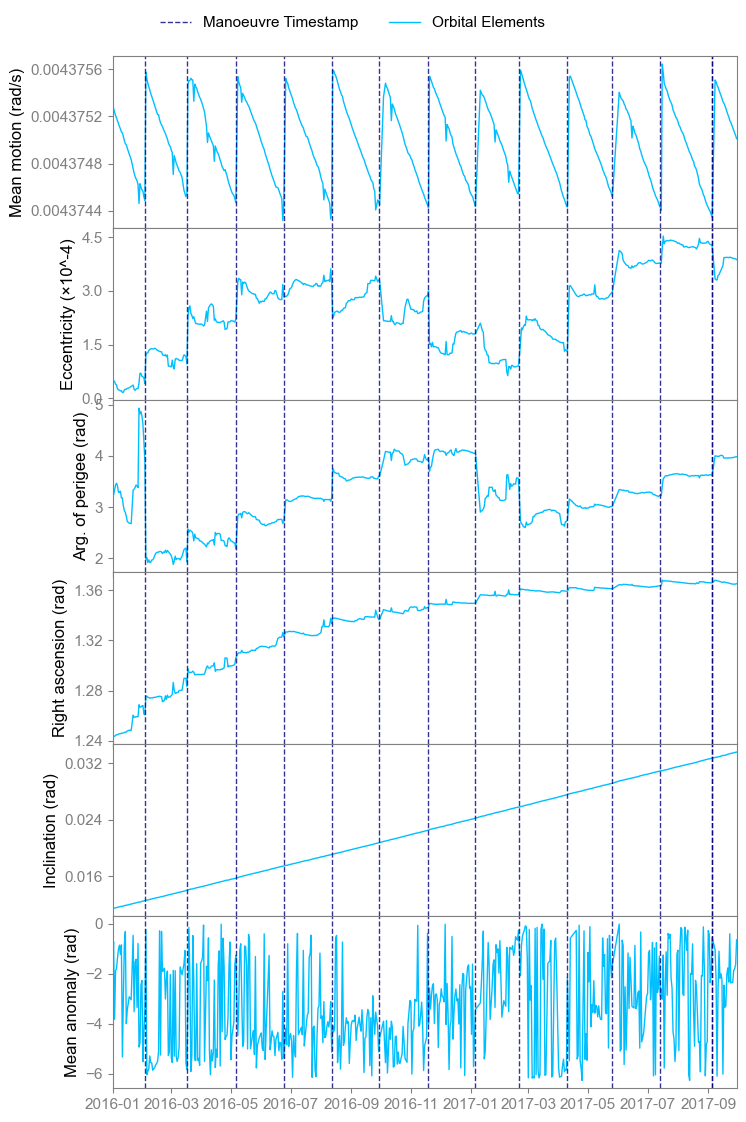

In [565]:
#Report Format
variables_to_plot =  ["Brouwer mean motion", "eccentricity_scaled", "argument of perigee","right ascension", "inclination", "mean anomaly"]
plot_multiple_variables_with_maneuvers(
    df_orbital,
    df_maneuver,
    "Fengyun_2F",
    variables_to_plot,
    "2016-01-01",
    "2017-09-30",
    save_path="figures/multivariable_fengyun2F.png"
)

Figure saved to figures/missingvalues_fengyun.png


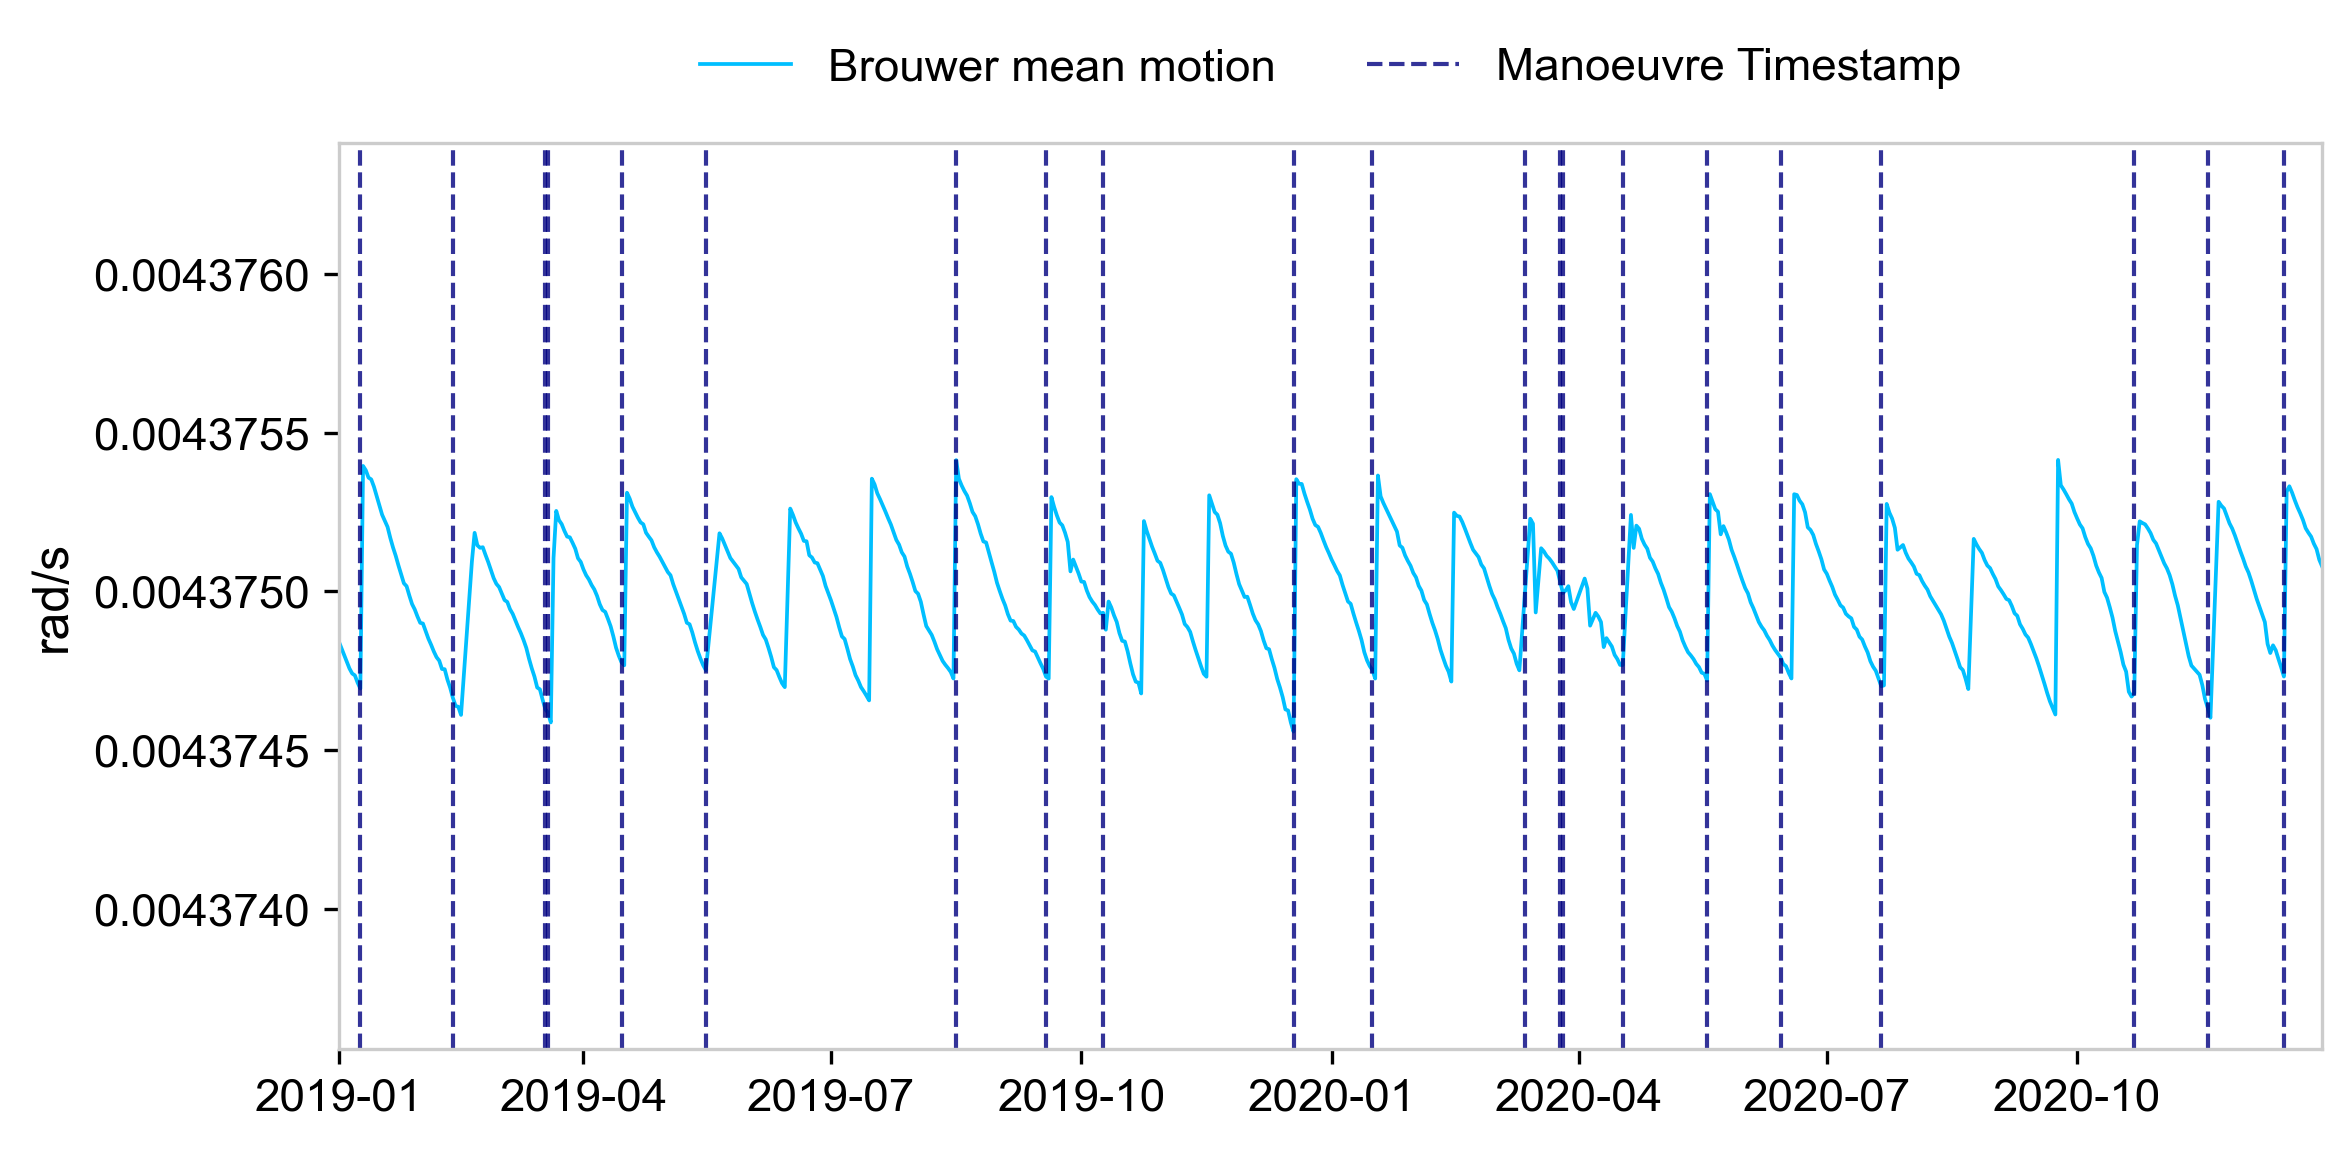

In [488]:
#Missing Values
plot_variable_with_maneuvers(df_orbital, df_maneuver, "Fengyun_4A", "Brouwer mean motion", "2019-01-01","2020-12-30", 
                             save_path="figures/multivariable_fengyun.png")

Figure saved to figures/consecutiveManuevers_fengyun.png


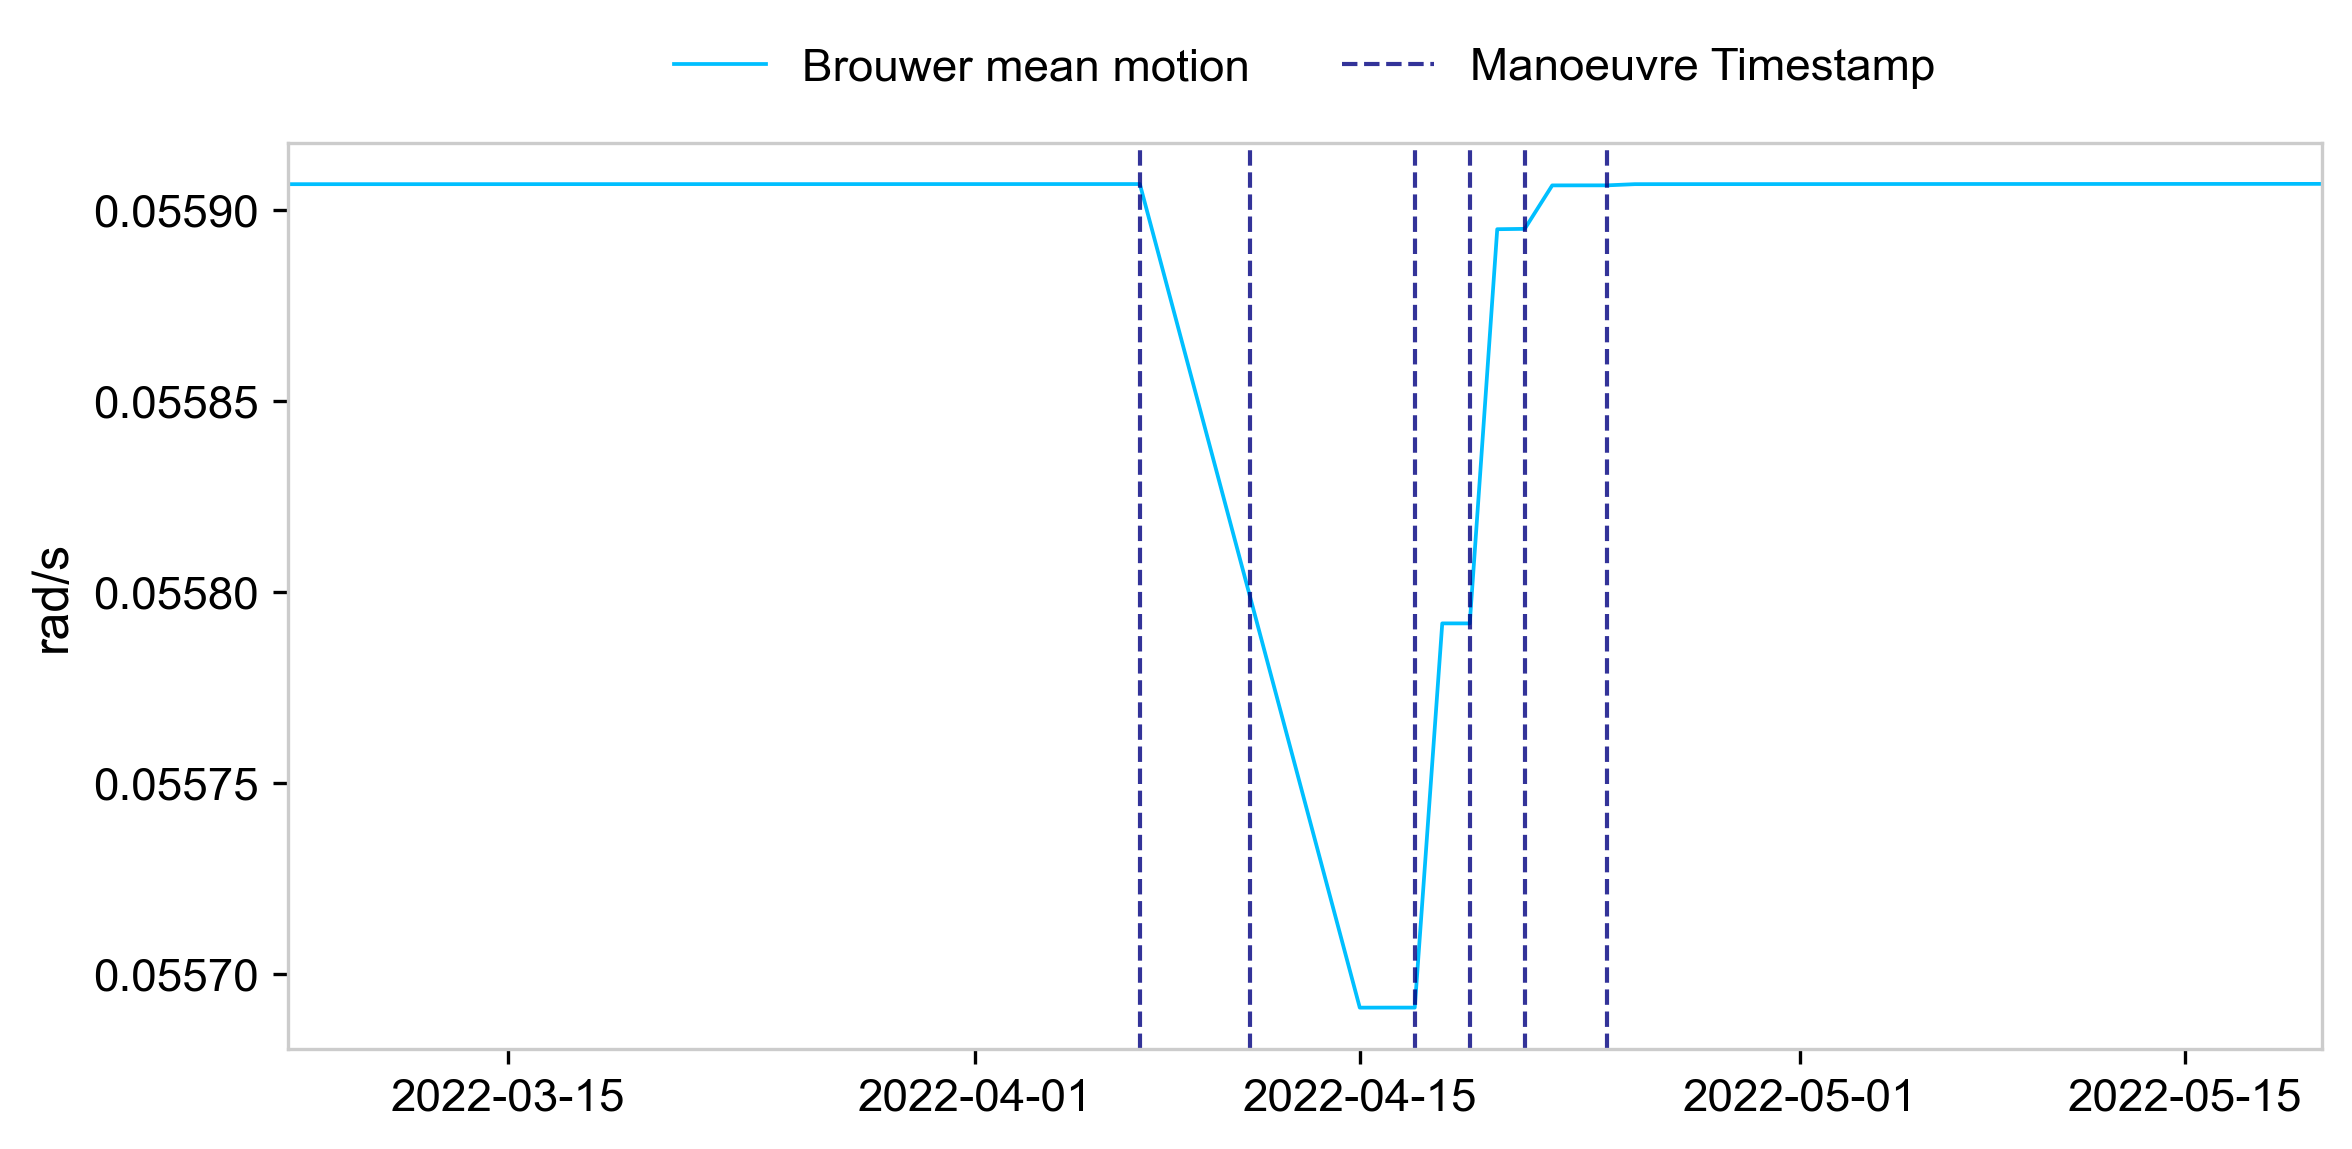

In [504]:
#Consecutive Manuevers
plot_variable_with_maneuvers(df_orbital, df_maneuver, "Jason_3", "Brouwer mean motion", 
                             "2022-03-07","2022-05-20", save_path="figures/consecutiveManuevers_fengyun.png")

Figure saved to figures/F2EA1.png


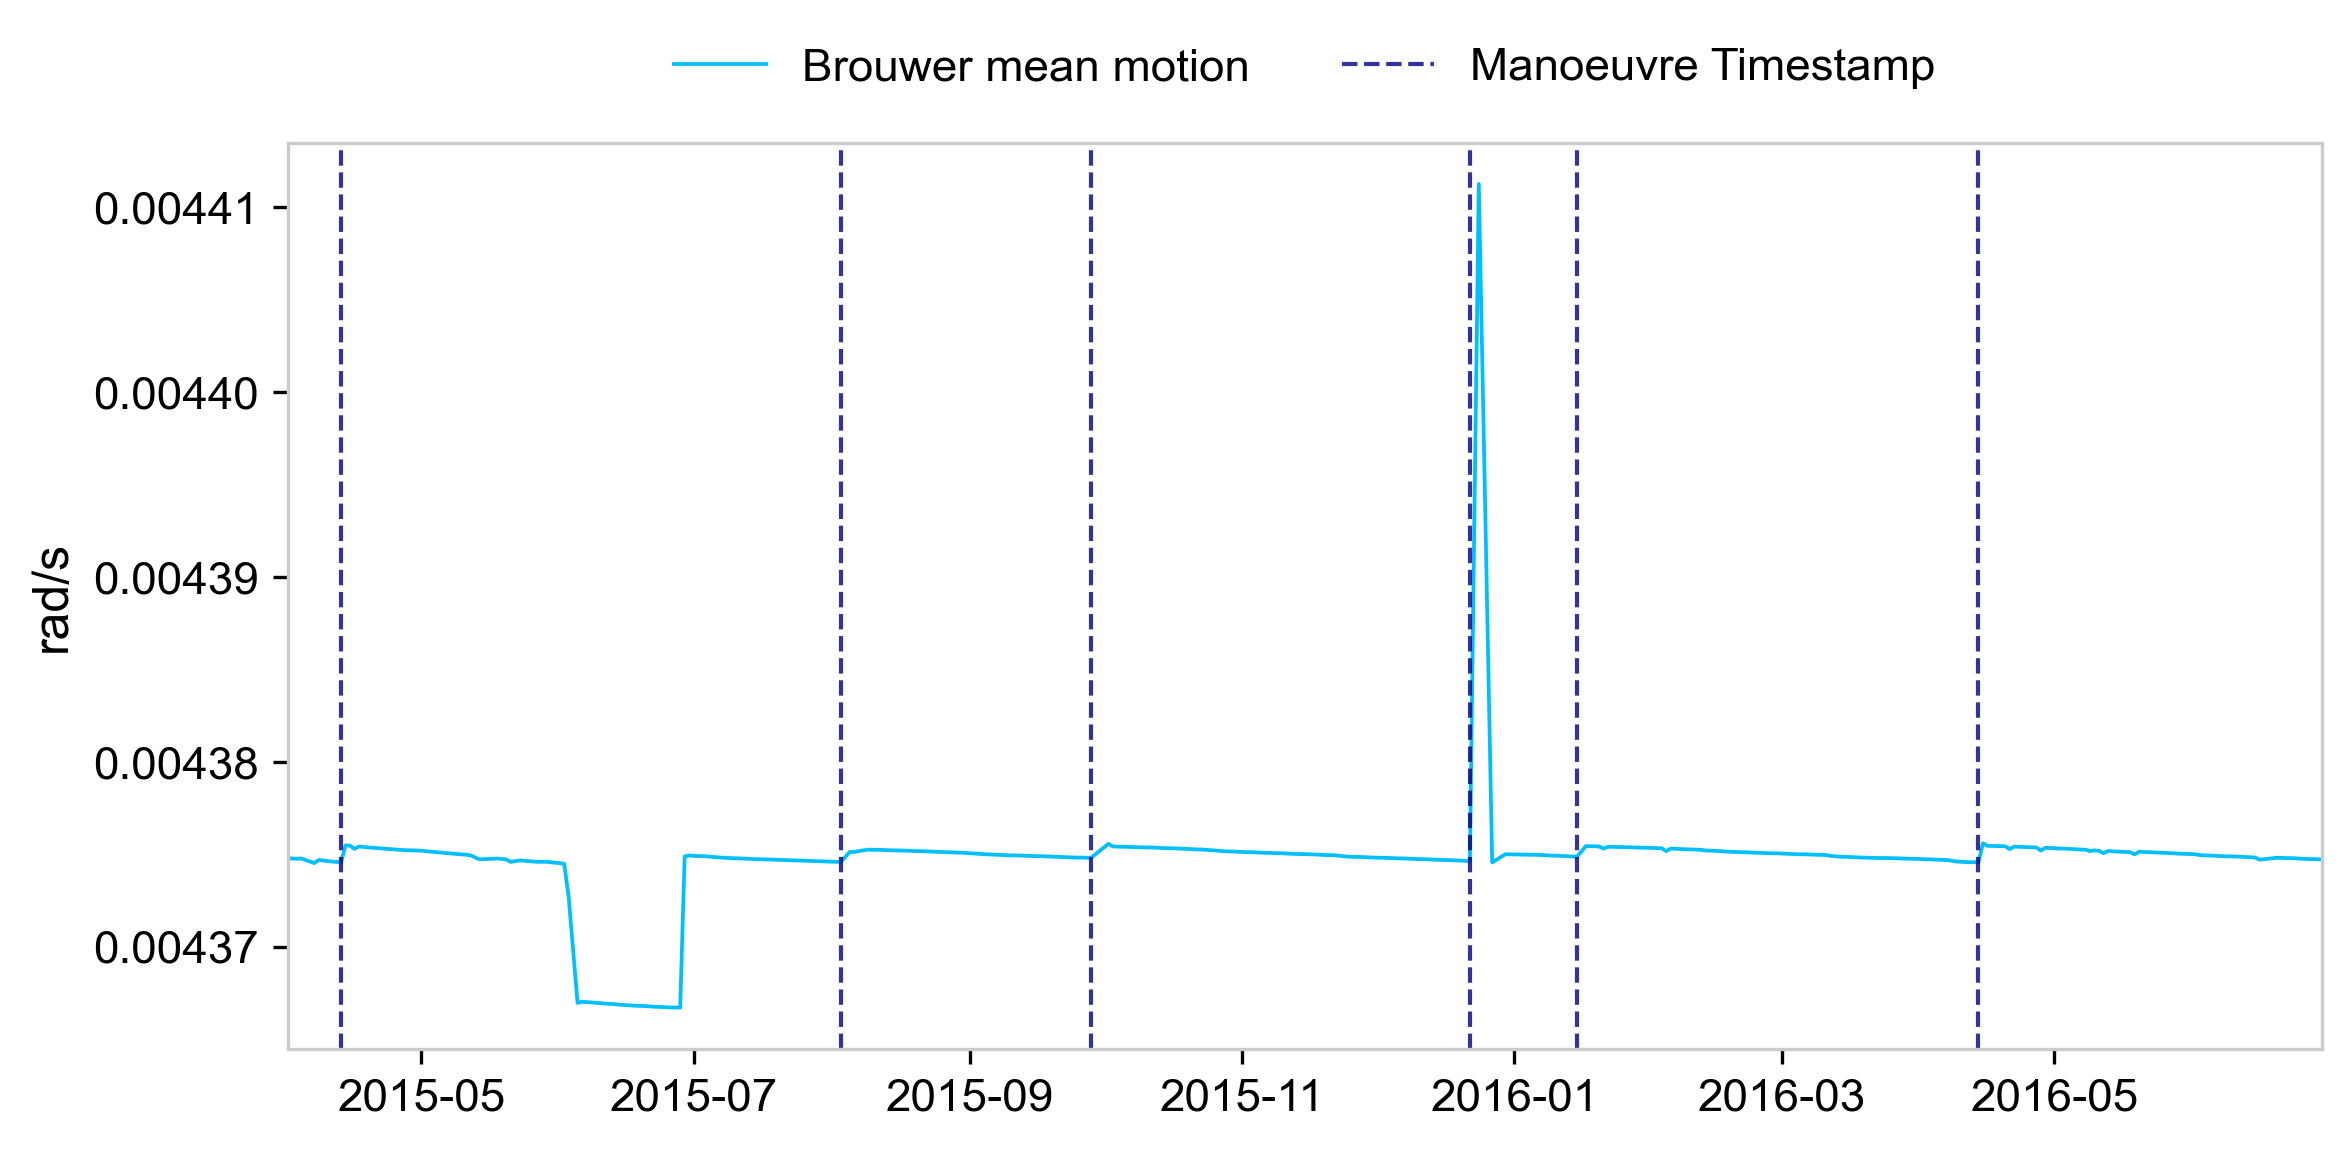

In [524]:
#Extreme Values
plot_variable_with_maneuvers(df_orbital, df_maneuver, "Fengyun_2E", "Brouwer mean motion","2015-04-01","2016-06-30", save_path="figures/F2EA1.png")

Figure saved to figures/drift.png


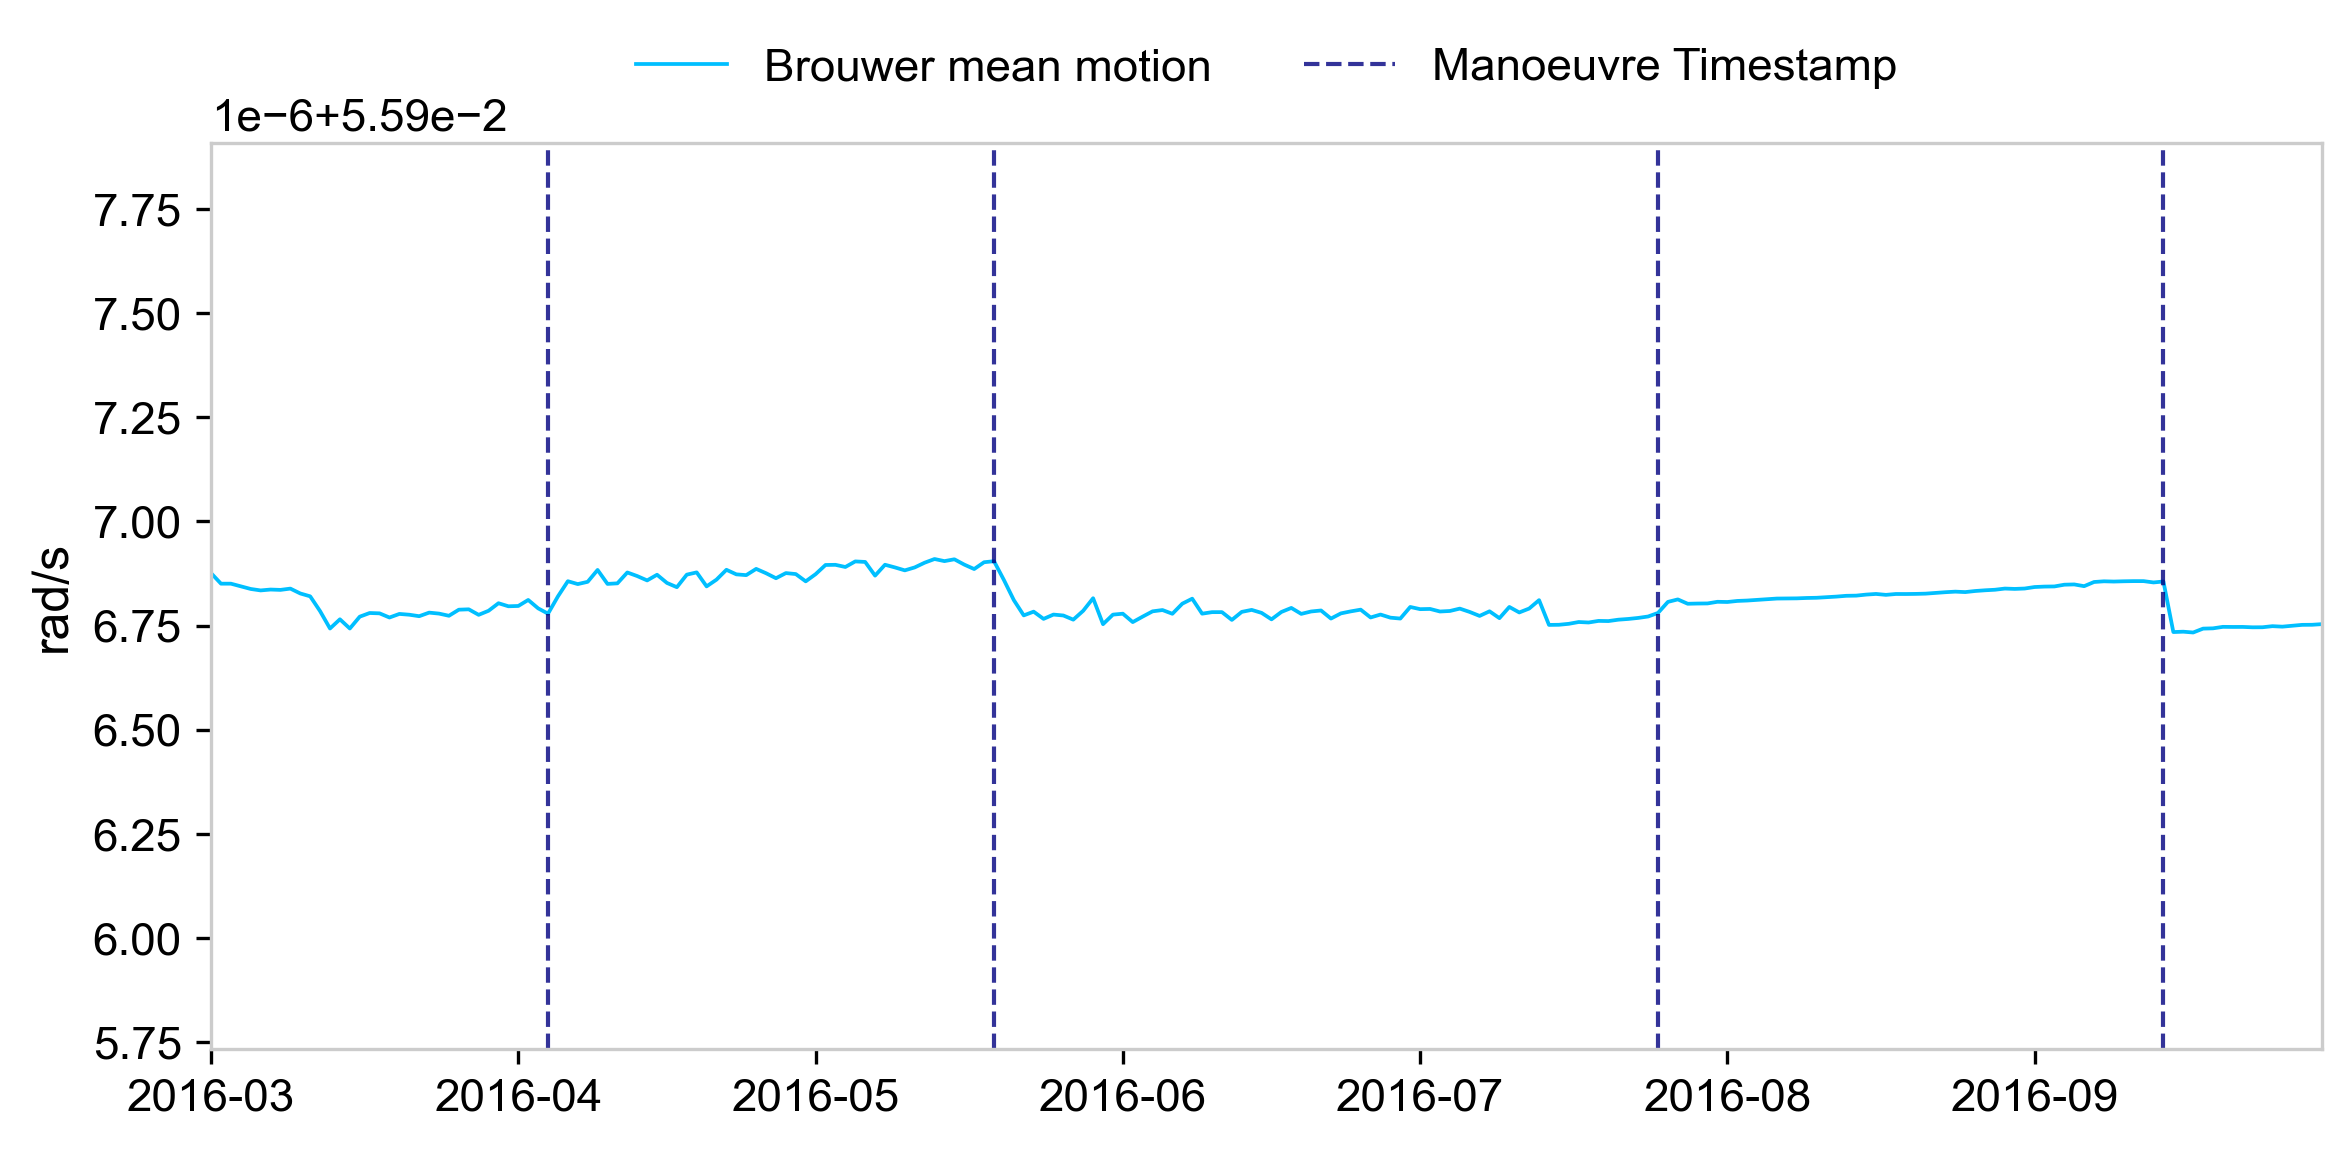

In [560]:
#Drift
plot_variable_with_maneuvers(df_orbital, df_maneuver, "Jason_3", "Brouwer mean motion","2016-03-01","2016-09-30", save_path="figures/drift.png")

Figure saved to figures/acfJason.png


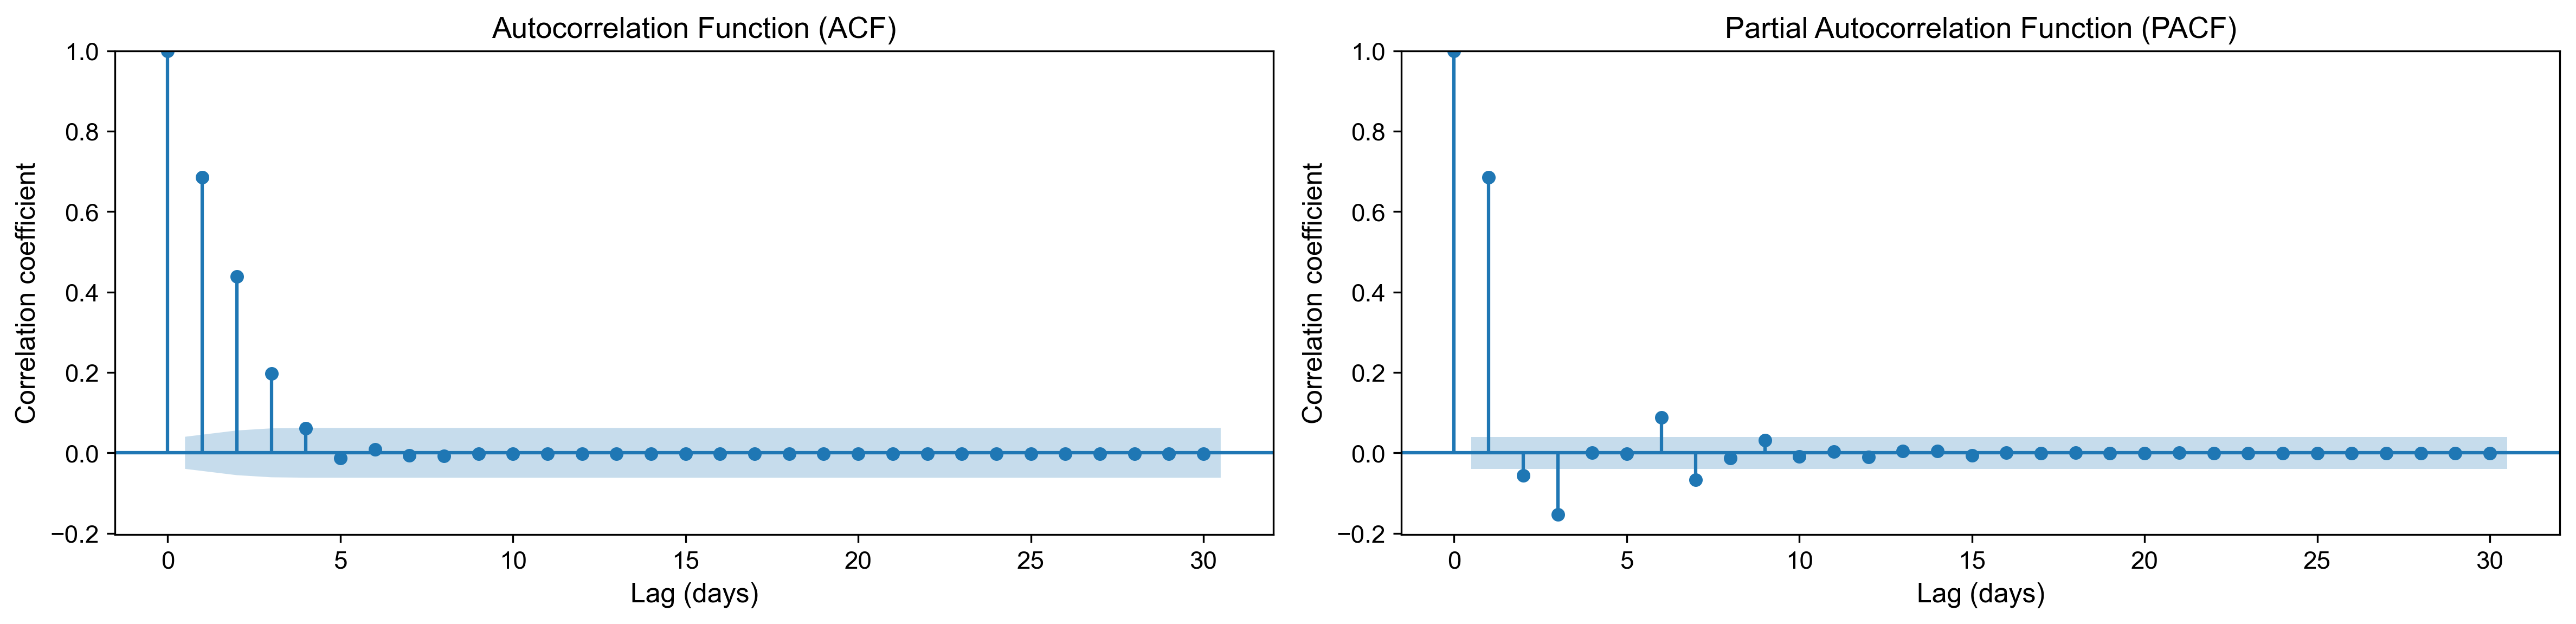

In [621]:
plot_acf_pacf(df_orbital, "Jason_3", "Brouwer mean motion",save_path="figures/acfJason.png",lags=30)

Figure saved to figures/acf4A.png


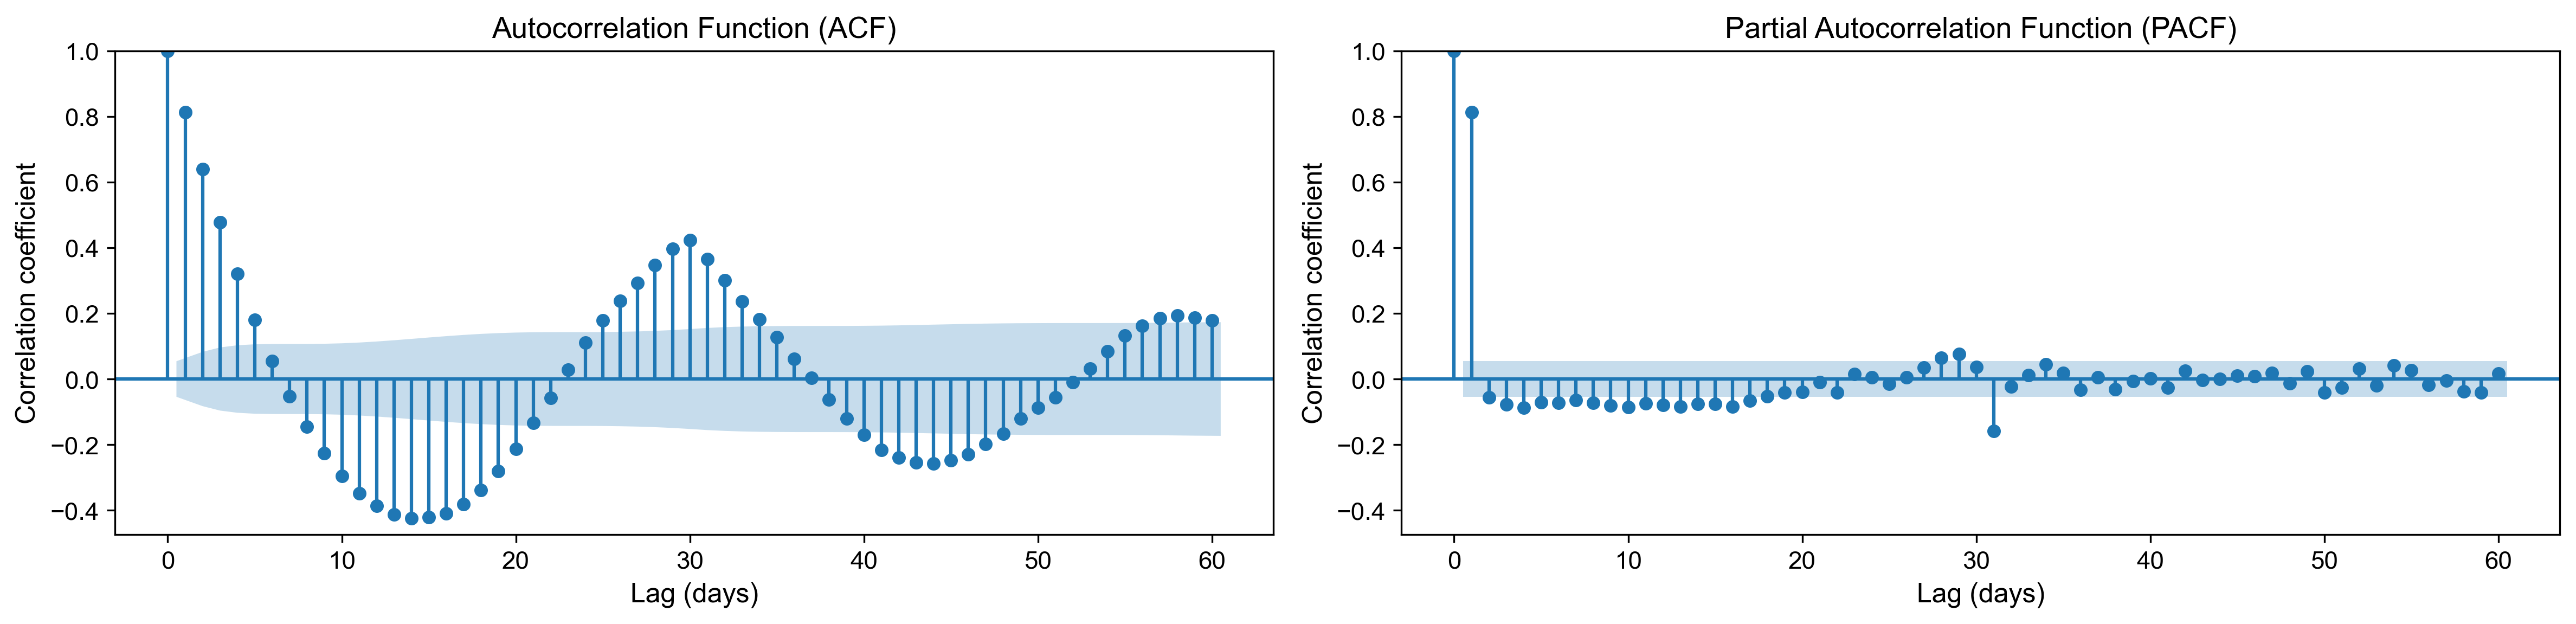

In [627]:
plot_acf_pacf(df_orbital, "Fengyun_4A", "Brouwer mean motion",save_path="figures/acf4A.png",lags=60)